In [23]:
import numpy as np
import pandas as pd
import xarray as xr
import napari
import os
from skimage import io
import morphotrack.image
import morphotrack.points
import morphotrack.align
import pickle
from matplotlib import pyplot as plt
from scipy import interpolate

import importlib
import morphotrack.nonlinear_align
import morphotrack.track
import morphotrack.image
import morphotrack.distance
importlib.reload(morphotrack.image)

import seaborn as sns
import pandas as pd

sns.set(font_scale = 1.3)
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':['Arial']})
sns.set_style("ticks")

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.cross_decomposition import PLSRegression
from sklearn import model_selection
from scipy.stats import zscore, pearsonr

In [3]:
track_ds_00 = xr.open_dataset('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/morphotrack/track_ds.nc').load()
track_ds_01 = xr.open_dataset('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/track_ds.nc').load()
track_ds_02 = xr.open_dataset('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/track_ds.nc').load()

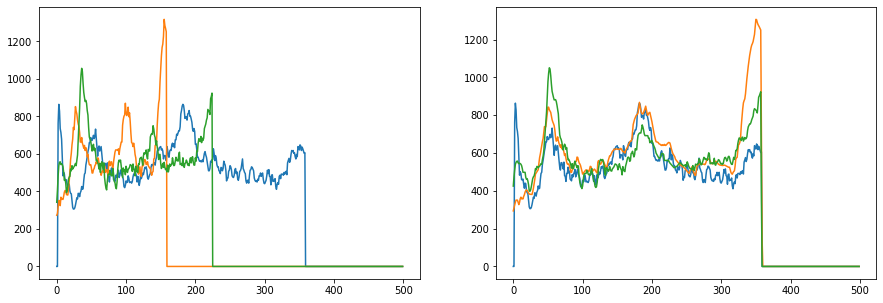

In [4]:
# standard alignment
std_00 = track_ds_00.Standard.isel(track=0).data
std_01 = track_ds_01.Standard.isel(track=0).data
std_02 = track_ds_02.Standard.isel(track=0).data

std_00_02, arg00_02 = morphotrack.nonlinear_align.non_linear_align_1d(std_02,std_00)
std_01_02, arg01_02 = morphotrack.nonlinear_align.non_linear_align_1d(std_02,std_01)
arg02_02 = np.arange(std_02.size)

standard_shifts = {
    'track_00':arg00_02,
    'track_01':arg01_02,
    'track_02':arg02_02,
}

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

axs[0].plot(std_02)
axs[0].plot(std_00)
axs[0].plot(std_01)

axs[1].plot(std_02)
axs[1].plot(std_00_02)
axs[1].plot(std_01_02)

In [5]:
# load images for visualization
image_set = {
    'track_00':[io.imread('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/morphotrack/R01_ch488_10um.tif'),
               io.imread('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/morphotrack/R01_ch561_10um.tif')],
    'track_01':[io.imread('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/R02_ch488_10um.tif'),
               io.imread('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/R01_ch561_10um.tif')],
    'track_02':[io.imread('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/R02_ch488_10um.tif'),
               io.imread('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/R01_ch561_10um.tif')],
}

In [6]:
# selection of the tracks
selection_set = {
    'track_00':xr.open_dataarray('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/morphotrack/filter_da.nc').load().all(axis=0),
    'track_01':xr.open_dataarray('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/filter_da.nc').load().all(axis=0),
    'track_02':xr.open_dataarray('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/filter_da.nc').load().all(axis=0)
}

tracks_original = {
    'track_00':track_ds_00,
    'track_01':track_ds_01,
    'track_02':track_ds_02
}

# select tracks based on the quality metrics
tracks = {}
for key in tracks_original:
    track_selection = selection_set[key].track[selection_set[key].data]
    track_ds = tracks_original[key].sel(track=track_selection.data)
    tracks[key] = track_ds
    
color_dict = {
    'track_00':'#b1eba7',
    'track_01':'#5dfa41',
    'track_02':'#148700',
}

In [26]:
round(standard_shifts['track_01'][layer_reference_time])

201

In [27]:
# combine everything for the analysis
combined_tracks = []
combined_local_flux = []
combined_flux = []
slicers = {}
layer_reference_time = 320
counter = 0

for key in tracks:
    track_ds = tracks[key]
    # get flux and local flux
    t = round(standard_shifts[key][layer_reference_time])
    lf = track_ds.Local_flux.copy()
    dist = morphotrack.distance.position2distance_xr(track_ds.Warped_position)

    flux = ((dist*lf).fillna(0)).sel(warped_time=slice(border_time, t)).sum(dim='warped_time')
    combined_flux.append(flux)
    combined_local_flux.append(lf.sel(warped_time=t).data)

    # shift all tracks 
    warp_arg = morphotrack.align.composite_displacement(
        track_ds.Total_arg.sel(displacement='t2s'),
        np.repeat(standard_shifts[key][:,np.newaxis], track_ds.track.size, axis=1).T
    )
    combined_tracks.append(morphotrack.align.positional_mapping(track_ds.Gray_counts, warp_arg))
    slicers[key] = slice(counter,counter+track_ds.track.size)
    counter += track_ds.track.size
    
combined_tracks = np.vstack(combined_tracks)
combined_local_flux = np.hstack(combined_local_flux)
combined_flux = np.hstack(combined_flux)

In [69]:
viewer = napari.Viewer()
viewer.add_image(combined_tracks)
viewer.add_image(zscore(combined_tracks,axis=0))
viewer.add_image(track_ds.Total_warped.sel(displacement='t2s'))

<Image layer 'Image [1]' at 0x7f625f1b6fd0>

<AxesSubplot:>

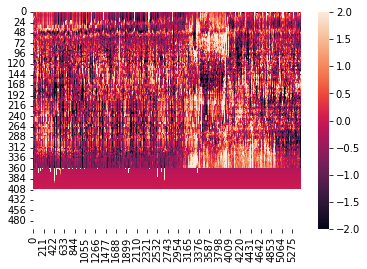

In [18]:
sns.heatmap(zscore(combined_tracks,axis=0).T, vmin=-2.0, vmax=2.0)

## Density plotting on isomap

459.0 669.0


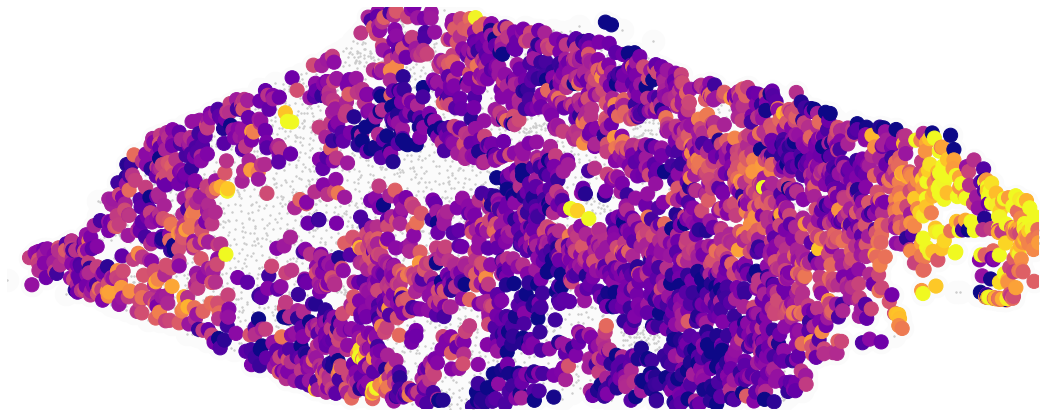

In [72]:
### density plotting at specified warped time point
# in a flattened surface
track_set = 'track_00'
time = 70 # (layer1: 30), (layer2: 50), upper layer3: 70, lower layer3: 130, (layer4:180), layer5:210

# get values
X0 = tracks_original[track_set].Seeds.data
isomap = Isomap(n_neighbors=20, n_components=2, n_jobs=-1)
isomap.fit(X0)
manifold0 = isomap.transform(X0)
X1 = tracks[track_set].Seeds.data
manifold1 = isomap.transform(X1)

# densities / counts
val = combined_tracks[slicers[track_set],:][:,time].copy()

# # normalize for visualization
vals = []
for tr in slicers.keys():
    vals.append(combined_tracks[slicers[tr],:][:,time])
vals = np.hstack(vals)

vmin = np.quantile(vals,0.05)
vmax = np.quantile(vals,0.95)
val[val<vmin] = vmin; val[val>vmax] = vmax

# plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(manifold0.max(axis=0) - manifold0.min(axis=0))/50)
ax.scatter(manifold0[:,0],manifold0[:,1],s=500, c='#fbfbfb')
ax.scatter(manifold0[:,0],manifold0[:,1],s=2, c='#cccccc')
ax.scatter(manifold1[:,0],manifold1[:,1],s=200,c=val,cmap='plasma')
ax.set_xlim([manifold0.min(axis=0)[0], manifold0.max(axis=0)[0]])
ax.set_ylim([manifold0.min(axis=0)[1], manifold0.max(axis=0)[1]])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
print(vmin, vmax)

## PCA and mapping onto the tissue

[0.2126654  0.12624743 0.10849245 0.06485862 0.04396384 0.03746488
 0.02582779 0.02366012 0.02019537 0.016793  ]
0.680168893753941
(0.48649189070349874, 1.2e-322)


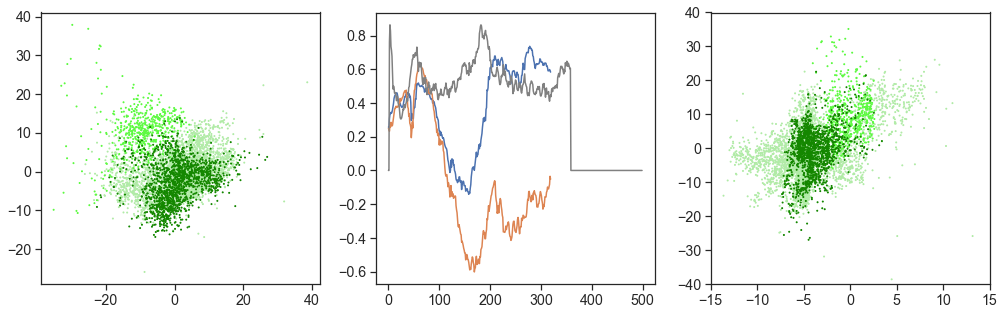

In [30]:
# trim the white matter to exclude the influence of the white matter.
trim_start = 0
trim_end = 320
combined_tracks_zscore = zscore(combined_tracks, axis=0)

pca = PCA().fit(combined_tracks_zscore[:,trim_start:trim_end])
pcs = pca.transform(combined_tracks_zscore[:,trim_start:trim_end])
pc1 = pcs[:,0]
pc2 = pcs[:,1]
pc3 = pcs[:,2]

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

colors = np.full(pc1.shape,'#b1eba7')
for key in slicers:
    colors[slicers[key]] = color_dict[key]

fig, axs = plt.subplots(ncols=3, figsize=(17,5))

axs[0].scatter(pc1,pc2,s=1,c=colors)
axs[1].plot(-loadings[:,0]) 
axs[1].plot(loadings[:,1]) 
axs[1].plot(std_02[trim_start:]/1000,c='gray')
axs[2].scatter(combined_flux, -pc1 ,s=1, c=colors)
axs[2].set_xlim([-15, 15]); axs[2].set_ylim([-40, 40])

component_num = 10
print(pca.explained_variance_ratio_[:component_num])
print(pca.explained_variance_ratio_[:component_num].sum())
print(pearsonr(-pc1, combined_flux))
plt.savefig('/home/tmurakami/Dropbox (Dropbox @RU)/19_publications/Fig5/PC1_flux.svg')

-12.848661105697706 14.666597424182267


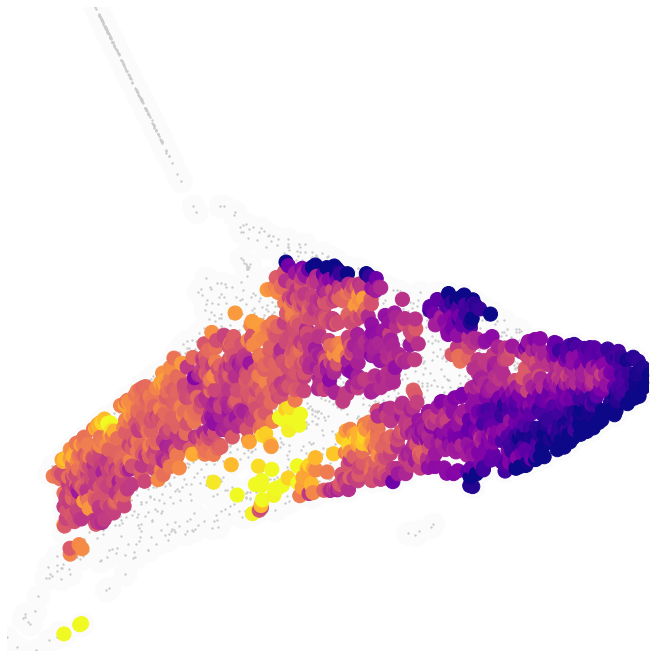

In [21]:
### PCA plotting
# in a flattened surface
track_set = 'track_02'
pc = -pc1

# get values
X0 = tracks_original[track_set].Seeds.data
isomap = Isomap(n_neighbors=20, n_components=2, n_jobs=-1)
isomap.fit(X0)
manifold0 = isomap.transform(X0)
X1 = tracks[track_set].Seeds.data
manifold1 = isomap.transform(X1)

# principle component
val = pc[slicers[track_set]].copy()

# # normalize for visualization
vmin = np.quantile(pc,0.05)
vmax = np.quantile(pc,0.95)
val[val<vmin] = vmin; val[val>vmax] = vmax

# plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(manifold0.max(axis=0) - manifold0.min(axis=0))/50)
ax.scatter(manifold0[:,0],manifold0[:,1],s=500, c='#fbfbfb')
ax.scatter(manifold0[:,0],manifold0[:,1],s=2, c='#cccccc')
ax.scatter(manifold1[:,0],manifold1[:,1],s=200,c=val,cmap='plasma')
ax.set_xlim([manifold0.min(axis=0)[0], manifold0.max(axis=0)[0]])
ax.set_ylim([manifold0.min(axis=0)[1], manifold0.max(axis=0)[1]])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
print(vmin, vmax)

In [32]:
# PLS instead of PCA
# how each positions of line are affected by local flux. test this with PLS.
# also read this. http://www.science.smith.edu/~jcrouser/SDS293/labs/lab11-py.html

def vip(x, y, model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_

    m, p = x.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips

In [33]:
combined_tracks_trimmed_zscore = combined_tracks_zscore[:,trim_start:trim_end]
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, combined_tracks_trimmed_zscore, combined_flux, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)
pls2 = PLSRegression(n_components=np.argmin(mse)).fit(combined_tracks_trimmed_zscore,combined_flux)

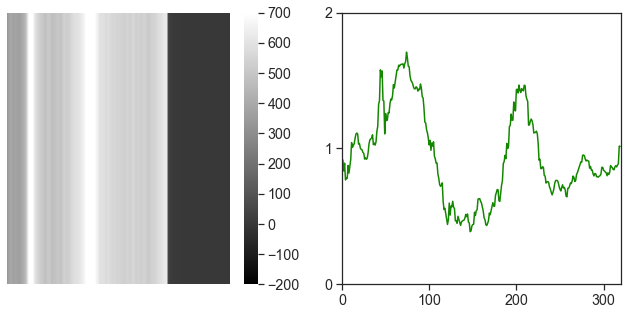

In [68]:
df = pd.DataFrame([pls2.predict(combined_tracks_trimmed_zscore).flatten(),combined_flux,colors]).T

fig, axs = plt.subplots(ncols=2, figsize=(11,5))
# axs[0].scatter(pls2.predict(combined_tracks_trimmed_zscore),combined_flux,s=1)
# sns.scatterplot(data=df, x=0, y=1, hue=2, s=1, ax=axs[0])
sns.heatmap(np.repeat(combined_tracks.mean(axis=0)[np.newaxis,:],5,axis=0),cmap='gray',vmin=-200,vmax=700, yticklabels=False,xticklabels=False,ax=axs[0])
axs[1].plot(vip(combined_tracks_trimmed_zscore,combined_flux,pls2),c='#148700')
axs[1].yaxis.set_ticks(np.asarray([0.0,1.0,2.0]))
axs[1].set_xlim([0, 320]); axs[1].set_ylim([0, 2.0])

plt.savefig('/home/tmurakami/Dropbox (Dropbox @RU)/19_publications/Fig5/vip_pls_meanheatmap.svg')

## Local thickness - density analysis

In [9]:
# calculate local thickness using aligned time.
corrs = {}
layer_depth_smooth_dict = {}
for key in tracks:
    track_ds = tracks[key]
    t = np.round(standard_shifts[key]).astype(int)# [layer_reference_time])

    layer_position = []
    for i, tr in enumerate(track_ds.track.data):
        warp = track_ds.Total_arg.sel(displacement='t2s').sel(track=tr).data
        interp_position = track_ds.Position.sel(track=tr).interp(time=warp)
        interp_position = interp_position.assign_coords(time=np.arange(warp.size))
        layer_position.append(interp_position)

    layer_position = xr.concat(layer_position,dim='track')
    # layer_position = layer_position.rename(time='warped_time')
    layer_depth = morphotrack.distance.position2distance_xr(layer_position).fillna(0)

    # because local thickness is not stable, take moving average
    window = 10
    layer_depth_smooth = layer_depth.rolling(time=window, center=True).mean().fillna(0)
    # transform time coordinate
    layer_depth_smooth = layer_depth_smooth.sel(time=t)
    layer_depth_smooth = layer_depth_smooth.assign_coords(time=track_ds.time.data)
    layer_depth_smooth_dict[key] = layer_depth_smooth
    
    density = track_ds.Total_warped.sel(displacement='t2s',time=t)
    density = density.assign_coords(time=track_ds.time.data)
    
    # calculate the depth wise 
    corr = []
    for ti in range(track_ds.time.size):
        r, p = pearsonr(density.sel(time=ti), layer_depth_smooth.sel(time=ti))
        corr.append(r)
    
    corrs[key] = np.asarray(corr)# [t]

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(-1.0, 1.0)

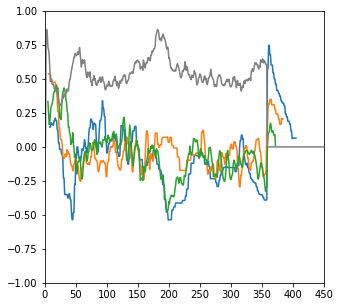

In [10]:
fig, axs = plt.subplots(figsize=(5,5))
axs.plot(corrs['track_00'])
axs.plot(corrs['track_01'])
axs.plot(corrs['track_02'])
axs.plot(std_02/1000,c='gray')
axs.set_xlim(0,450)
axs.set_ylim(-1,1)

In [11]:
viewer = napari.Viewer()
viewer.add_image(zscore(track_ds.Total_warped.sel(displacement='t2s').data,axis=0).T,colormap='gray',blending='additive')
viewer.add_image(-zscore(layer_depth_smooth.data,axis=0).T,colormap='gray',blending='additive')

<Image layer 'Image [1]' at 0x7fe17ee7b370>

## Local flux and density analysis

In [12]:
corrs_lf = {}
local_flux_dict = {}
layer_reference_time = 180

for key in tracks:
    track_ds = tracks[key]
    t_ref = round(standard_shifts[key][layer_reference_time])
    t = np.round(standard_shifts[key]).astype(int)

    density = track_ds.Total_warped.sel(displacement='t2s',time=t)
    density = density.assign_coords(time=track_ds.time.data)
    local_flux = tracks[key].Local_flux# .sel(warped_time=t)
    # local_flux = local_flux.assign_coords(warped_time=track_ds.time.data)
    local_flux_dict[key] = local_flux.sel(warped_time=t_ref)
    corr = []
    for ti in range(track_ds.time.size):
        r, p = pearsonr(density.sel(time=ti), local_flux.sel(warped_time=t_ref))
        corr.append(r)

    corrs_lf[key] = np.asarray(corr)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(-1.0, 1.0)

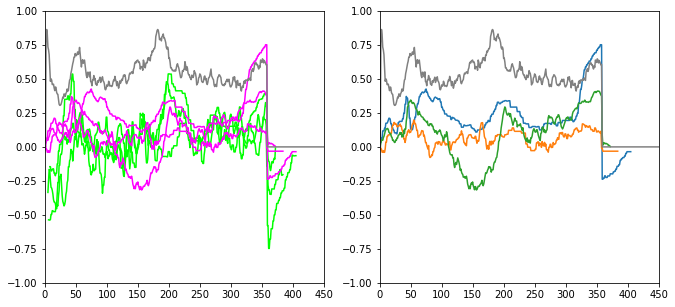

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(11,5))
axs[0].plot(-corrs['track_00'],c='lime')
axs[0].plot(-corrs['track_01'],c='lime')
axs[0].plot(-corrs['track_02'],c='lime')
axs[0].plot(corrs_lf['track_00'],c='magenta')
axs[0].plot(corrs_lf['track_01'],c='magenta')
axs[0].plot(corrs_lf['track_02'],c='magenta')
axs[0].plot(std_02/1000,c='gray')
axs[0].set_xlim(0,450)
axs[0].set_ylim(-1,1)

axs[1].plot(corrs_lf['track_00'])
axs[1].plot(corrs_lf['track_01'])
axs[1].plot(corrs_lf['track_02'])
axs[1].plot(std_02/1000,c='gray')
axs[1].set_xlim(0,450)
axs[1].set_ylim(-1,1)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(-1.0, 1.0)

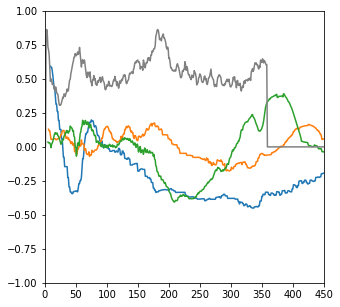

In [14]:
# How about correlation between thickness and local flux?
corr_d_lf = {}
for key in tracks:
    corr = []
    for ti in range(track_ds.time.size):
        r, p = pearsonr(layer_depth_smooth_dict[key].sel(time=ti), local_flux_dict[key])
        corr.append(r)
    corr_d_lf[key] = np.asarray(corr)

fig, axs = plt.subplots(figsize=(5,5))
axs.plot(corr_d_lf['track_00'])
axs.plot(corr_d_lf['track_01'])
axs.plot(corr_d_lf['track_02'])
axs.plot(std_02/1000,c='gray')
axs.set_xlim(0,450)
axs.set_ylim(-1,1)

## Collective analysis of local flux and local thickness

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


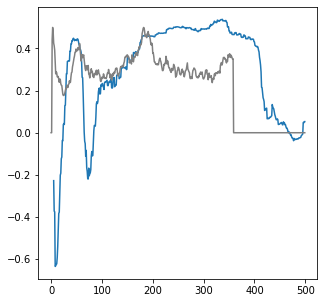

In [15]:
layerdepth_combined = xr.concat(list(layer_depth_smooth_dict.values()),dim='track')
localflux_combined = xr.concat(list(local_flux_dict.values()),dim='track')
corr_ldlf_combined = []
for ti in range(track_ds.time.size):
    r, p = pearsonr(layerdepth_combined.sel(time=ti), localflux_combined.data)
    corr_ldlf_combined.append(r)
    
corr_ldlf_combined = np.asarray(corr_ldlf_combined)
fig, axs = plt.subplots(figsize=(5,5))
axs.plot(-corr_ldlf_combined)
axs.plot(std_02/std_02.max()/2,c='gray')

In [228]:
# check local thickness itself
tr = 'track_02'
viewer = napari.Viewer()
viewer.add_image(layer_depth_smooth_dict[tr].data)

<Image layer 'Image' at 0x7f565b52aa90>

### Conclution: local thickness is not a reliable measurement
Because it can be affected by systematic bias of nonlinear alignment

## PCA of local density

[0.24742219 0.11309252 0.09997812 0.06360802 0.05195701 0.04795208
 0.03807061 0.02533876 0.02256552 0.01583417]
0.7258189824401816


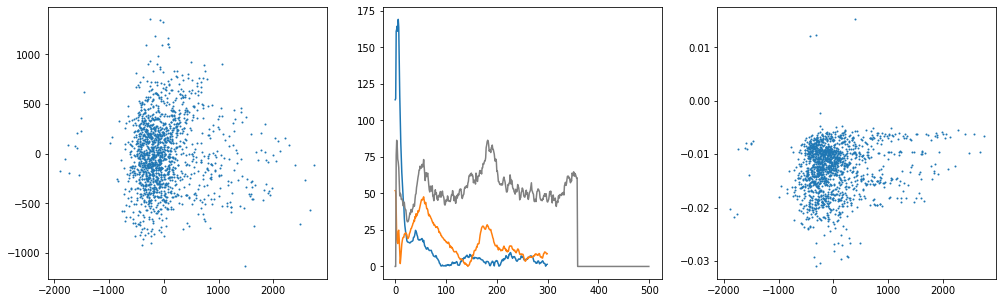

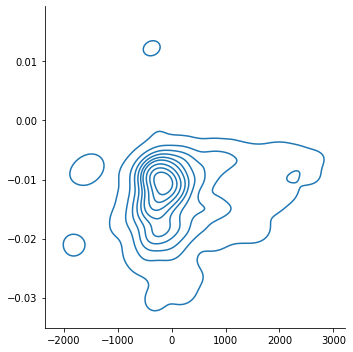

In [16]:
# tissue wise version
i = 2

# trim the white matter to exclude the influence of the white matter.
trim = 300
pca = PCA().fit(combined_tracks[slicers[i],:trim])
pcs = pca.transform(combined_tracks[slicers[i],:trim])
pc1 = pcs[:,0]
pc2 = pcs[:,1]
pc3 = pcs[:,2]


fig, axs = plt.subplots(ncols=3, figsize=(17,5))
axs[0].scatter(pc1,pc2,s=1)
#print(pca.explained_variance_ratio_)

component_num = 10
print(pca.explained_variance_ratio_[:component_num])
print(pca.explained_variance_ratio_[:component_num].sum())
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
# fig, axs = plt.subplots(ncols=1, figsize=(5,5))
axs[1].plot(abs(loadings[:,0]))
axs[1].plot(abs(loadings[:,1]))
# axs[1].plot(abs(loadings[:,2]))
axs[1].plot(std_02/10,c='gray')

axs[2].scatter(pc1,combined_local_flux[slicers[i]],s=1)
sns.displot(x=pc1, y=combined_local_flux[slicers[i]], kind='kde', thresh=0.01)
# axs[2].scatter(pc1[slicers[2]],combined_local_flux[slicers[2]],s=1)
# axs[2].set_ylim([-0.03, 0.03])

In [19]:
converter = {'track_00':0,'track_01':1,'track_02':2}
key = 'track_00'
layer_reference_time = 180
p = pc2[slicers[converter[key]]]
t = round(standard_shifts[key][layer_reference_time])

pos0 = tracks[key].Warped_position.sel(warped_time=0).data
post = tracks[key].Warped_position.sel(warped_time=t).data
local_flux = tracks[key].Local_flux.sel(warped_time=t).data

color_vis = morphotrack.image.vector_color_mapping(local_flux,colormap='plasma',scaling=True,low_p=5,high_p=95)
color_vis_p = morphotrack.image.vector_color_mapping(p,colormap='plasma',scaling=True,low_p=5,high_p=95)

viewer = napari.Viewer()
viewer.add_image(image_set[key][0],colormap='gray',blending='additive')
viewer.add_points(pos0, size=10, face_color = color_vis, edge_width=0, symbol='disc')
viewer.add_points(pos0, size=10, face_color = color_vis_p, edge_width=0, symbol='disc')

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<Points layer 'pos0 [1]' at 0x7fe17ea8a5e0>

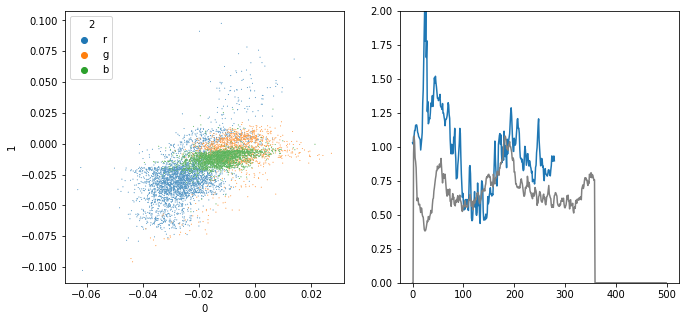

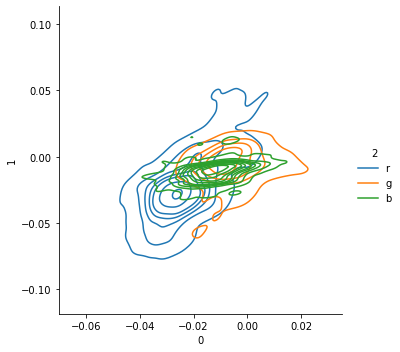

In [300]:
sns.displot(data=df, x=0, y=1, hue=2, kind='kde', thresh=0.03)

In [301]:
#